In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split


In [2]:
logP_data = pd.read_csv('./data/logP.csv')
logP_data

,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6
...,...,...
14605,CCC(SC)Br,2.7
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8
14607,CC(C)NNC,0.4
14608,C[C@H]1CCC[CH]1,3.4


<Axes: >

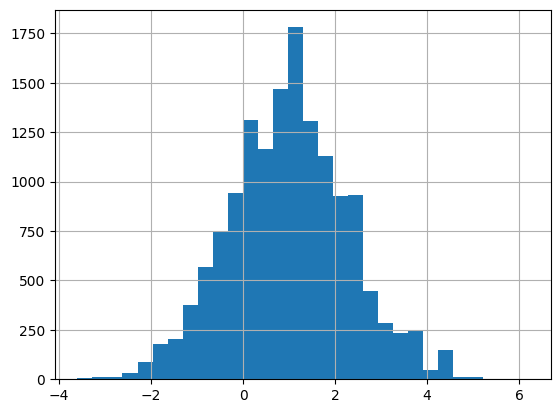

In [3]:
# 목적 변수 분포
logP_data.logP.hist(bins=30)


- Chem.MolFromSmiles() 함수를 이용하여 SMILES로부터 Mol 객체를 얻는다

In [4]:
# 사본 데이터프레임 사용
df = logP_data.copy()
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# 리스트를 생성하는 다른 방법
# df['mol'] = [Chem.MolFromSmiles(x) for x in df['smiles']]
df[:3]

,smiles,logP,mol
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f560e04fae0>
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f560e04f6f0>
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f560cb5e730>


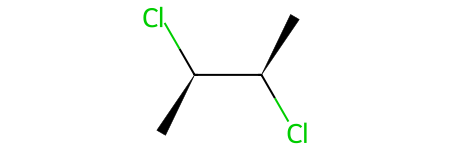

In [5]:
df.mol[0]

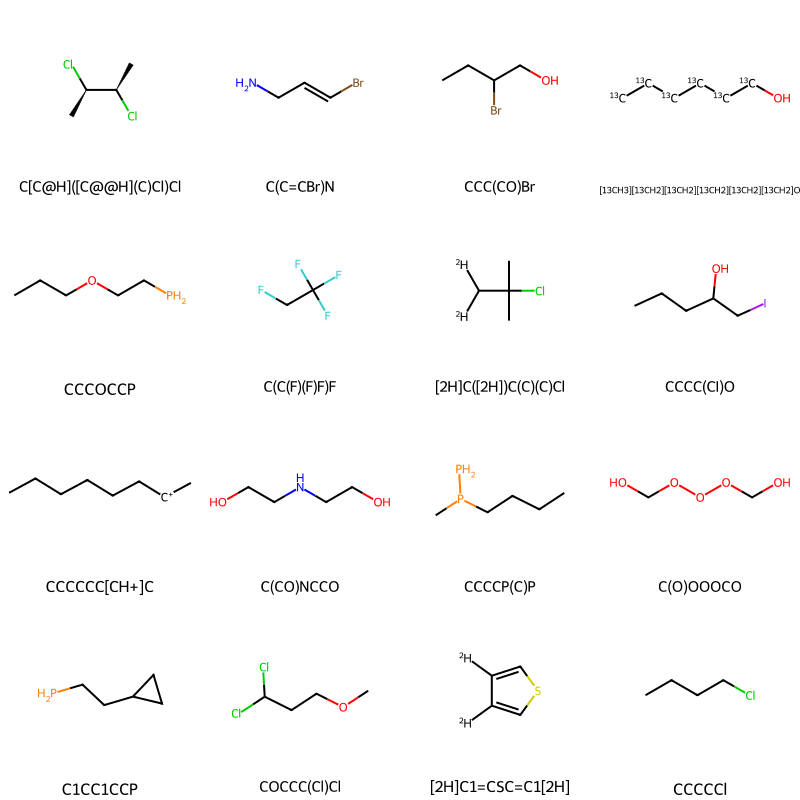

In [6]:
# 16개 이미지를 그리드 형태로 그리기
mols = df['mol'][:16]
Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=list(df['smiles'][:16].values))

### 특성 추가하기

- Chem 모듈에서 분자의 다양한 속성 정보를 추출하는 함수를 제공한다
- mol 객체로부터 분자를 구성하는 원자수를 얻으려면 다음과 같은, mol 객체가 제공하는 함수를 사용하면 된다
 - GetNumAtoms(): 모든 원자 수 얻기
 - GetNumHeavyAtoms(): 수소를 제외한 원자의 수 얻기


In [7]:
# AddHs() mol 객체에 수소 원자를 추가로 표시한다

df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a5813f0>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a581460>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a5814d0>,15,6


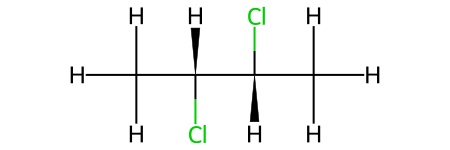

In [8]:
df.mol[0]

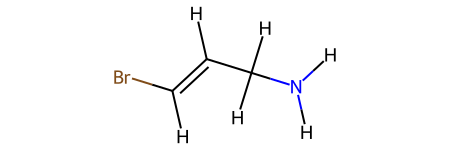

In [9]:
df.mol[1]

- 분자를 구성하는 각 원자별 갯수를 추가하기
- GetSubstructMatches()를 사용하면 분자 내에 특정한 패턴이 들어있는지를 찾아낼 수 있다

In [10]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['smiles'][0])
print(df['mol'][0].GetSubstructMatches(c_patt))

C[C@H]([C@@H](C)Cl)Cl
((0,), (1,), (2,), (3,))


In [11]:
# 임의의 원자를 몇개 포함하고 있는지를 얻는 함수
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

In [12]:
number_of_atoms(['C','O', 'N', 'Cl'], df)
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a5813f0>,14,6,4,0,0,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a581460>,11,5,3,0,1,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f560a5814d0>,15,6,4,1,0,0


## 훈련/검증 데이터 나누기

In [13]:
# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

# 훈련과 검증 데이터를 나눈다 (검증 데이터로 10% 할당)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1)


Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


- 아래는 훈련과 검증 데이터를 나누는 개념도이다. 주어진 데이터 순서를 유지하면서 데이터를 나누려면 shuffle=False 옵션을 지정하면 된다 (디폴트 값은 랜덤하게 섞는다)

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-12-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2011.45.47.png?raw=1" width=300 align='left'>